Carrying the same basic concept as notebook 1.


the idea in this notebook involves no prior model, just trying to put a feedforward neural network with reduced state model instead of OpInf. 
More advanced version will not flatten anything and use convolutions.

instead of linear RHS we also put quadratic term. But our quadratic model is very simple Linear tanh scheme for now.

In [1]:
import os
import opinf
import scipy.signal
# import cv2
os.getcwd()

'/home/ajivani/WLROM/WhiteLight'

In [2]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf as op

In [3]:
import time

In [4]:
from sunpy.visualization import colormaps as cm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
adjoint=True

In [7]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

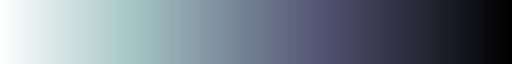

In [9]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

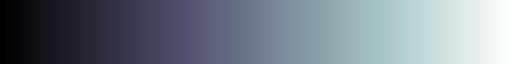

In [10]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [11]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300,
       # figsize=(9, 3)
       )
plt.rc("font",
       family="serif",
       size=10
       )
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=False)
# plt.rc("text", usetex=True)

### Setup training and testing data

In [12]:
m = 71

In [13]:
t_vec = (np.linspace(40, 180, m) - 40) / 60
t_vec

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333])

In [14]:
dt = t_vec[1] - t_vec[0]

In [15]:
nTrainTime = np.argwhere(t_vec == (120 - 40) / 60)[0, 0]

In [16]:
nTrainTime

40

In [17]:
nTrainTimeAll = np.argwhere(np.linspace(2, 180, 90) == 40)[0,0]

In [18]:
t_train = t_vec[:(nTrainTime + 1)]
t_train[-1] * 60 + 40

120.0

In [19]:
t_test = t_vec[(nTrainTime + 1):]
t_test

array([1.36666667, 1.4       , 1.43333333, 1.46666667, 1.5       ,
       1.53333333, 1.56666667, 1.6       , 1.63333333, 1.66666667,
       1.7       , 1.73333333, 1.76666667, 1.8       , 1.83333333,
       1.86666667, 1.9       , 1.93333333, 1.96666667, 2.        ,
       2.03333333, 2.06666667, 2.1       , 2.13333333, 2.16666667,
       2.2       , 2.23333333, 2.26666667, 2.3       , 2.33333333])

In [20]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [21]:
X = X_orig.reshape((64 * 256, 90, 278))[:, (nTrainTimeAll):, :]

In [22]:
import netCDF4 as nc
ds = nc.Dataset("./20150315_CR2161_code_stable_tDecay2h.nc")
successfulRuns = ds['runs'].successfulRuns + 30
successfulRuns

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

In [23]:
train_test_sims = np.load("./CR2161_AWSoM2T_CME_tDecay2h_Polar_Clusters.npz")
train_sim = train_test_sims["training_id"]
test_sim = train_test_sims["test_id"]
train_sim, test_sim

(array([  0,   1,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  30,
         31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  44,  45,  48,
         49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  61,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,
         79,  82,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  98, 100, 102, 103, 104, 105, 106, 107, 108, 110, 113, 114,
        115, 116, 118, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 138, 139, 140, 142, 143, 146, 147, 148,
        149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        165, 166, 167, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 194, 196, 197,
        198, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 216, 217, 219, 220, 221, 222, 223

In [24]:
tt_sim = np.sort(np.hstack((train_sim, test_sim)))

In [25]:
X_train_ttrain = X[:, :(nTrainTime + 1), train_sim]
X_train_ttrain.shape

(16384, 41, 222)

In [26]:
X_test = X[:, :, test_sim]

In [27]:
X_train_test_ttrain = X[:, :(nTrainTime + 1), :]

In [28]:
X_train_ttrain.shape

(16384, 41, 222)

In [29]:
rom_1 = op.ContinuousOpInfROM(modelform="AH")
basis_1 = op.pre.PODBasis().fit(X_train_ttrain[:, :, 0], residual_energy=1e-8)
basis_1.r

32

In [30]:
reduced_states = basis_1.encode(X_train_ttrain[:, :, 0])

In [31]:
reduced_states.shape

(32, 41)

In [32]:
reduced_states[1, :]

array([ 5.18753867,  5.4877632 ,  5.74297088,  5.93984572,  6.07472786,
        6.14135307,  6.13742178,  6.06361853,  5.92100359,  5.70977877,
        5.42965491,  5.08355595,  4.67775802,  4.21922311,  3.71461306,
        3.16796246,  2.58665005,  1.98280391,  1.36212992,  0.73077039,
        0.09351159, -0.54198027, -1.16760093, -1.77649704, -2.36307699,
       -2.92112476, -3.44261899, -3.92287053, -4.35932236, -4.74802847,
       -5.08321308, -5.36596717, -5.59438547, -5.76788039, -5.88884099,
       -5.95946237, -5.98421062, -5.96423347, -5.90416973, -5.80922226,
       -5.68420387])

### Construction of NODE Architecture

In [33]:
device

device(type='cuda', index=0)

In [34]:
t_train

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333])

In [35]:
data_size = t_train.shape[0]
batch_time = 5
batch_size = 10
print("Data size = ", data_size, " Batch time = ", batch_time, " Batch size = ", batch_size)

Data size =  41  Batch time =  5  Batch size =  10


In [36]:
t = torch.tensor(np.float32(t_train)).to(device)

In [37]:
t.dtype

torch.float32

In [38]:
true_y0 = torch.from_numpy(np.float32(reduced_states[:, 0]))
true_y0 = true_y0.reshape((1, len(true_y0))).to(device)
true_y0.shape

torch.Size([1, 32])

In [39]:
true_y0.dtype

torch.float32

In [40]:
reduced_states.shape

(32, 41)

In [41]:
yreduced = np.float32(reduced_states.T)
true_y = torch.from_numpy(np.expand_dims(yreduced, axis=1)).to(device)
true_y.shape

torch.Size([41, 1, 32])

In [42]:
true_y.dtype

torch.float32

Need functions for getting batch, getting true x, getting ODE func - where we run the "loss" metric compared to the true simulation.

The batch is taking IC as values at different times in the training set, and the solution as the values following the IC upto some predefined batch size for time.

In [43]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [44]:
by0, bt, by = get_batch()

In [45]:
batch_time

5

In [46]:
by0.shape, bt.shape, by.shape

(torch.Size([10, 1, 32]), torch.Size([5]), torch.Size([5, 10, 1, 32]))

In [47]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [48]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(32, 50),
            nn.Tanh(),
            nn.Linear(50, 32),
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(528, 32),
            nn.Tanh(),
        )

        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
        for m in self.net2.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    
    def quadratic_y(self, y):
        y_np = torch.squeeze(y, axis=1)
        y_np_quad = torch.zeros((y_np.shape[0], 1, int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
        
#         y_np = np.squeeze(y.cpu().detach().numpy(), axis=1)
#         y_np_quad = np.zeros((y_np.shape[0], int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
        for i in range(y_np.shape[0]):
#             y_np_quad[i, :] = np.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]
            y_np_quad[i, 0, :] = torch.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]
            
#         y_t_quad = torch.from_numpy(np.expand_dims(np.float32(y_np_quad), axis=1)).to(device)

#         return y_t_quad
        return y_np_quad.to(device)
            
    def forward(self, t, y):
            return self.net1(y) + self.net2(self.quadratic_y(y))

In [49]:
ii = 0
func = ODEFunc().to(device)
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

In [50]:
niters = 2000
test_freq = 5

In [51]:
func

ODEFunc(
  (net1): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=32, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=528, out_features=32, bias=True)
    (1): Tanh()
  )
)

In [52]:
func(t, by0)

tensor([[[-1.3435,  0.3181,  1.8518, -0.6492, -0.2702, -1.1609,  0.6418,
          -0.9684,  0.4223,  0.3208, -0.5058,  0.3960,  1.2017, -0.7753,
           0.0186,  0.4887,  0.6707,  2.4085,  1.5802,  1.2438, -0.6935,
          -1.5361,  0.9209,  0.8585,  0.3817, -0.1870, -1.2471,  1.8615,
           1.2117, -0.9599,  1.7493, -0.6953]],

        [[-1.3388,  0.2699,  1.8842, -0.6129, -0.2979, -1.1010,  0.7070,
          -0.9836,  0.4228,  0.2873, -0.5558,  0.4147,  1.2122, -0.7934,
          -0.0520,  0.5540,  0.6886,  2.3887,  1.5644,  1.2396, -0.6594,
          -1.5084,  0.9332,  0.8185,  0.4134, -0.1562, -1.2457,  1.8379,
           1.1455, -0.9833,  1.7311, -0.7293]],

        [[-1.5295,  0.3821,  1.8930, -0.6929, -0.3289, -1.2116,  0.4774,
          -0.9227,  0.5652,  0.3587, -0.5118,  0.3563,  1.2265, -0.7200,
           0.0077,  0.4653,  0.4015,  2.5296,  1.6493,  1.3601, -0.8221,
          -1.4252,  0.9968,  1.0523,  0.4438, -2.1922, -1.1857,  1.8960,
           1.2768, -0.9617

In [53]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

Iter 0005 | Total Loss 1.038526
Iter 0010 | Total Loss 0.929425
Iter 0015 | Total Loss 0.834712
Iter 0020 | Total Loss 0.759686
Iter 0025 | Total Loss 0.712697
Iter 0030 | Total Loss 0.665449
Iter 0035 | Total Loss 0.637338
Iter 0040 | Total Loss 0.615118
Iter 0045 | Total Loss 0.604113
Iter 0050 | Total Loss 0.597580
Iter 0055 | Total Loss 0.575757
Iter 0060 | Total Loss 0.556193
Iter 0065 | Total Loss 0.541696
Iter 0070 | Total Loss 0.526669
Iter 0075 | Total Loss 0.510173
Iter 0080 | Total Loss 0.500533
Iter 0085 | Total Loss 0.494325
Iter 0090 | Total Loss 0.487374
Iter 0095 | Total Loss 0.480799
Iter 0100 | Total Loss 0.472304
Iter 0105 | Total Loss 0.461217
Iter 0110 | Total Loss 0.457962
Iter 0115 | Total Loss 0.456147
Iter 0120 | Total Loss 0.448360
Iter 0125 | Total Loss 0.442764
Iter 0130 | Total Loss 0.441005
Iter 0135 | Total Loss 0.433349
Iter 0140 | Total Loss 0.432639
Iter 0145 | Total Loss 0.438958
Iter 0150 | Total Loss 0.442645
Iter 0155 | Total Loss 0.442643
Iter 016

Iter 1290 | Total Loss 0.265913
Iter 1295 | Total Loss 0.257823
Iter 1300 | Total Loss 0.264189
Iter 1305 | Total Loss 0.264906
Iter 1310 | Total Loss 0.268879
Iter 1315 | Total Loss 0.266559
Iter 1320 | Total Loss 0.262818
Iter 1325 | Total Loss 0.272701
Iter 1330 | Total Loss 0.267377
Iter 1335 | Total Loss 0.258130
Iter 1340 | Total Loss 0.248394
Iter 1345 | Total Loss 0.248768
Iter 1350 | Total Loss 0.255110
Iter 1355 | Total Loss 0.255399
Iter 1360 | Total Loss 0.253492
Iter 1365 | Total Loss 0.247903
Iter 1370 | Total Loss 0.247851
Iter 1375 | Total Loss 0.241472
Iter 1380 | Total Loss 0.240135
Iter 1385 | Total Loss 0.251108
Iter 1390 | Total Loss 0.253536
Iter 1395 | Total Loss 0.242185
Iter 1400 | Total Loss 0.240848
Iter 1405 | Total Loss 0.245911
Iter 1410 | Total Loss 0.239353
Iter 1415 | Total Loss 0.235650
Iter 1420 | Total Loss 0.242285
Iter 1425 | Total Loss 0.241109
Iter 1430 | Total Loss 0.240214
Iter 1435 | Total Loss 0.236744
Iter 1440 | Total Loss 0.231975
Iter 144

**good point**: is it even a good idea to train two nets simultaneously by just taking naive sum of predictions and plugging into loss? see responses on: https://stackoverflow.com/questions/67872719/is-it-possible-to-combine-2-neural-networks

Effectively, we have two things to check over here:

1. What is the error within the training set, if we provide initial condition y0?

2. What is the error on the held out part of the data with the same IC?

We could just plot the 2D images and check this qualitatively / with RMSE, with the caveat that RMSE is not really the metric we want to be optimizing for. Also is evaluating error between reduced _as opposed to_ full state appropriate?

If we tried everything with train times in first sim  i.e. `true_y` was derived from reduced states constructed off `X_train_ttrain[:, :, 0]` then `X_train_ttrain[:, :, 0]` is basically decoded shape for the `true_y`.

Predicted `y` i.e. `pred_y` needs to be decoded.

In [54]:
with torch.no_grad():
    pred_y = odeint(func, true_y0, t)

In [55]:
pred_y.shape

torch.Size([41, 1, 32])

In [56]:
pred_y_np = pred_y.cpu().numpy()[:, 0, :].T

In [57]:
pred_y_decoded = basis_1.decode(pred_y_np)

In [58]:
true_y_decoded = X_train_ttrain[:, :, 0]

In [59]:
pred_y_decoded.shape

(16384, 41)

visualization for if we are able to replicate training properly.

In [60]:
64 * 256

16384

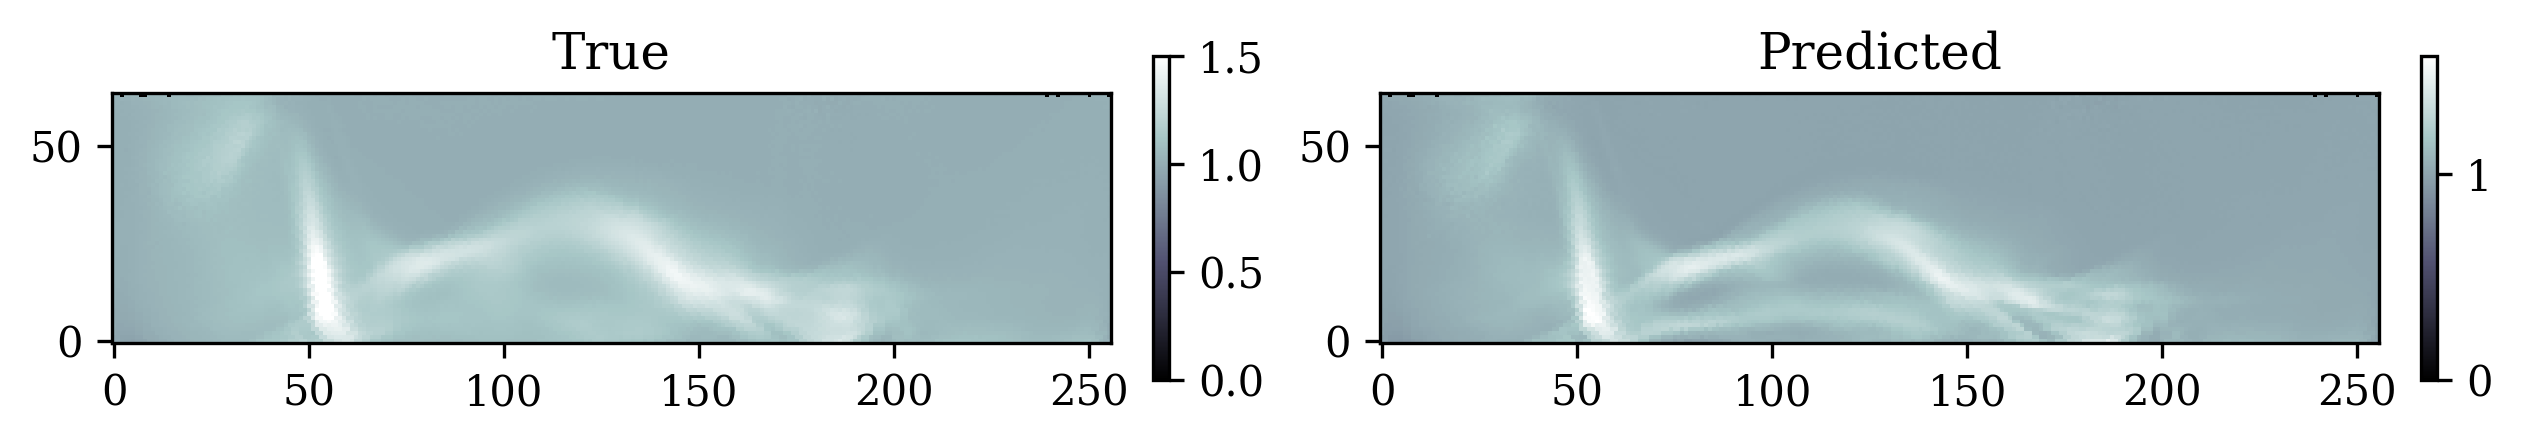

In [61]:
# def visualize():
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded[:, 40].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_decoded[:, 40].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

by comparison to notebook 1?



testing times comparison to notebook 1?

In [62]:
t_full = torch.tensor(np.float32(t_vec)).to(device)

In [63]:
with torch.no_grad():
    pred_y_train_sim_fullt = odeint(func, true_y0, t_full)

In [64]:
pred_y_train_sim_fullt_decoded = basis_1.decode(pred_y_train_sim_fullt.cpu().numpy()[:, 0, :].T)

In [65]:
pred_y_train_sim_fullt_decoded.shape

(16384, 71)

In [66]:
true_y_decoded_fullt = X[:, :, 0]
true_y_decoded_fullt.shape

(16384, 71)

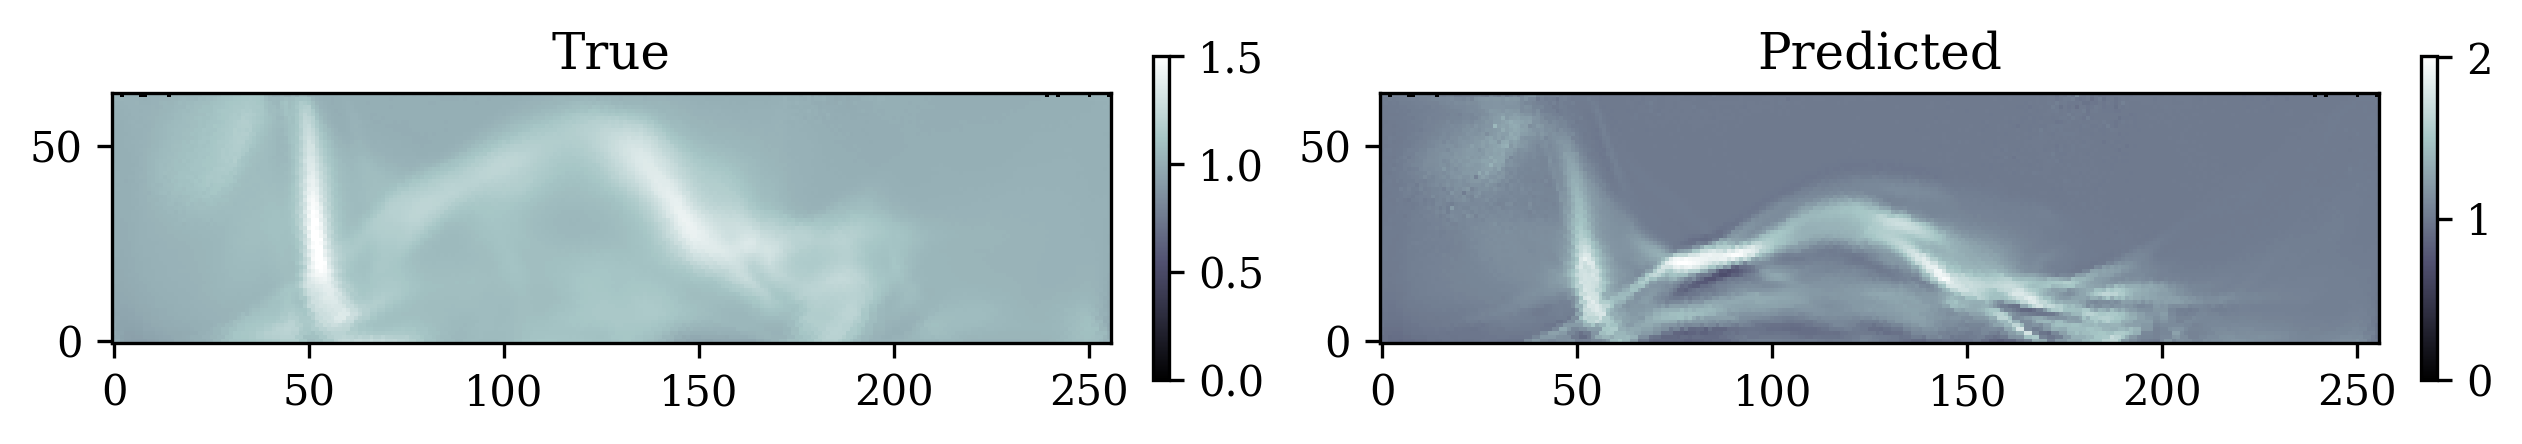

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded_fullt[:, 70].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_train_sim_fullt_decoded[:, 70].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

Try the same example but with prior learnt OpInf model.

#### Scratch Start

In [ ]:
32 * (32 + 1) / 2

In [ ]:
np.outer([1, 2, 3, 4], [2, 3, 4, 5])

In [ ]:
np.tril_indices(4)

In [ ]:
v_out_flat = np.outer([1, 2, 3, 4], [2, 3, 4, 5])[np.tril_indices(4)]
v_out_flat

In [ ]:
torch.tensor(v_out_flat)

In [ ]:
vquad_t = torch.from_numpy(np.float32(v_out_flat)).reshape((1, len(v_out_flat))).to(device)

In [ ]:
v_np = vquad_t.cpu().numpy().flatten()

In [ ]:
v_np

In [ ]:
# test bed for getting quadratic term in neural net implemented
aaa = np.array([[[1, 2, 3]],
               [[10, 11, 12]]
               ])
aaa


aaa[0, :, :]


sq = np.squeeze(aaa, axis=1)

def qy3(y):
    y_np = np.squeeze(y, axis=1)
    y_np_quad = np.zeros((y_np.shape[0], int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
    for i in range(y_np.shape[0]):
        y_np_quad[i, :] = np.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]

    y_t_quad = torch.from_numpy(np.expand_dims(np.float32(y_np_quad), axis=1)).to(device)

    return y_t_quad

qy3(aaa)

aaat = qy3(aaa)
aaat.shape

#### Scratch End